# Taxi GPS data processing

In this example, we will introduce how to use the TransBigData package to efficiently process Taxi GPS data.  
Firstly, import the TransBigData and read the data using pandas

In [15]:
import transbigdata as tbd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('data/TaxiData-Sample.csv', header=None)
data.columns = ['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus', 'Speed']
data.head()

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed
0,34745,20:27:43,113.806847,22.623249,1,27
1,34745,20:24:07,113.809898,22.627399,0,0
2,34745,20:24:27,113.809898,22.627399,0,0
3,34745,20:22:07,113.811348,22.628067,0,0
4,34745,20:10:06,113.819885,22.647800,0,54


In [16]:
# Read the GeoDataFrame of the study area
sz = gpd.read_file(r'data/sz.json')
sz.crs = None
sz.head()

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.10006 22.53431, 114.10083 22.534..."
1,114.041535,22.546180,福田,"POLYGON ((113.98578 22.51348, 114.00553 22.513..."
2,114.270206,22.596432,盐田,"POLYGON ((114.19799 22.55673, 114.19817 22.556..."
3,113.851387,22.679120,宝安,"MULTIPOLYGON (((113.81831 22.54676, 113.81948 ..."
4,113.926290,22.766157,光明,"POLYGON ((113.99768 22.76643, 113.99704 22.766..."


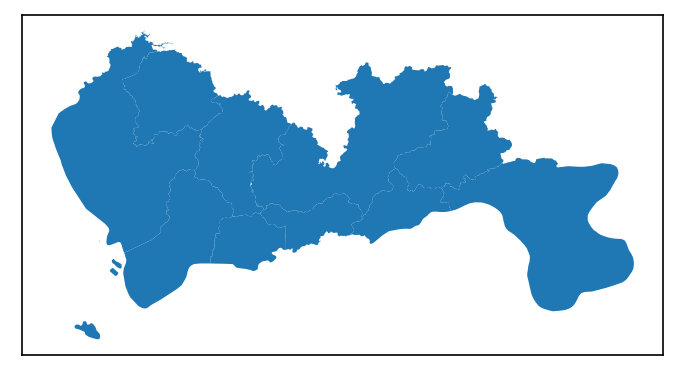

In [17]:
fig = plt.figure(1, (8, 3), dpi=150) 
ax1 = plt.subplot(111)
sz.plot(ax=ax1)
plt.xticks([], fontsize=10)
plt.yticks([], fontsize=10);

# Data pre-processing

TransBigData integrates several common methods for data pre-processing. Using `the tbd.clean_outofshape` method, given the data and the GeoDataFrame of the study area, it can delete the data outside the study area. The `tbd.clean_taxi_status` method can filters out the data with instantaneous changes in passenger status(OpenStatus). When using the preprocessing method, the corresponding column names need to be passed in as parameters：

In [18]:
# Data Preprocessing
# Delete the data outside of the study area
data = tbd.clean_outofshape(data, sz, col=['Lng', 'Lat'], accuracy=500)

# Delete the data with instantaneous changes in passenger status
data = tbd.clean_taxi_status(data, col=['VehicleNum', 'Time', 'OpenStatus'])

# Data Gridding

The most basic way to express the data distribution is in the form of geograpic grids; after the data gridding, each GPS data point is mapped to the corresponding grid. For data gridding, you need to determine the gridding parameters at first(which can be interpreted as defining a grid coordinate system):

In [19]:
# Data gridding
# Define the bounds and generate gridding parameters
bounds = [113.6, 22.4, 114.8, 22.9]
params = tbd.grid_params(bounds, accuracy=500)
print(params)

(113.6, 22.4, 0.004872390756896538, 0.004496605206422906)


After obtaining the gridding parameters, the next step is to map the GPS is to their corresponding grids. Using the `tbd.GPS_to_grids`, it will generate the `LONCOL` column and the `LATCOL` column. The two columns together can specify a grid:

In [20]:
# Mapping GPS data to grids
data['LONCOL'], data['LATCOL'] = tbd.GPS_to_grids(data['Lng'], data['Lat'], params)
data.head()

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed,LONCOL,LATCOL
0,34745,20:27:43,113.806847,22.623249,1,27,42,50
1,27368,09:08:53,113.805893,22.624996,0,49,42,50
2,22998,10:51:10,113.806931,22.624166,1,54,42,50
3,22998,10:11:50,113.805946,22.625433,0,43,42,50
4,22998,10:12:05,113.806381,22.623833,0,60,42,50


Count the amount of data in each grids:

In [21]:
# Aggregate data into grids
datatest = data.groupby(['LONCOL', 'LATCOL'])['VehicleNum'].count().reset_index()
datatest.head()

,LONCOL,LATCOL,VehicleNum
0,36,63,2
1,36,66,1
2,36,67,8
3,37,62,9
4,37,63,8


Generate the geometry of the grids and transform it into a GeoDataFrame:

In [22]:
# Generate the geometry for grids
datatest['geometry'] = tbd.gridid_to_polygon(datatest['LONCOL'], datatest['LATCOL'], params)

# Change it into GeoDataFrame
# import geopandas as gpd
datatest = gpd.GeoDataFrame(datatest)
datatest.head()

,LONCOL,LATCOL,VehicleNum,geometry
0,36,63,2,"POLYGON ((113.77297 22.68104, 113.77784 22.681..."
1,36,66,1,"POLYGON ((113.77297 22.69453, 113.77784 22.694..."
2,36,67,8,"POLYGON ((113.77297 22.69902, 113.77784 22.699..."
3,37,62,9,"POLYGON ((113.77784 22.67654, 113.78271 22.676..."
4,37,63,8,"POLYGON ((113.77784 22.68104, 113.78271 22.681..."


Plot the generated grids:



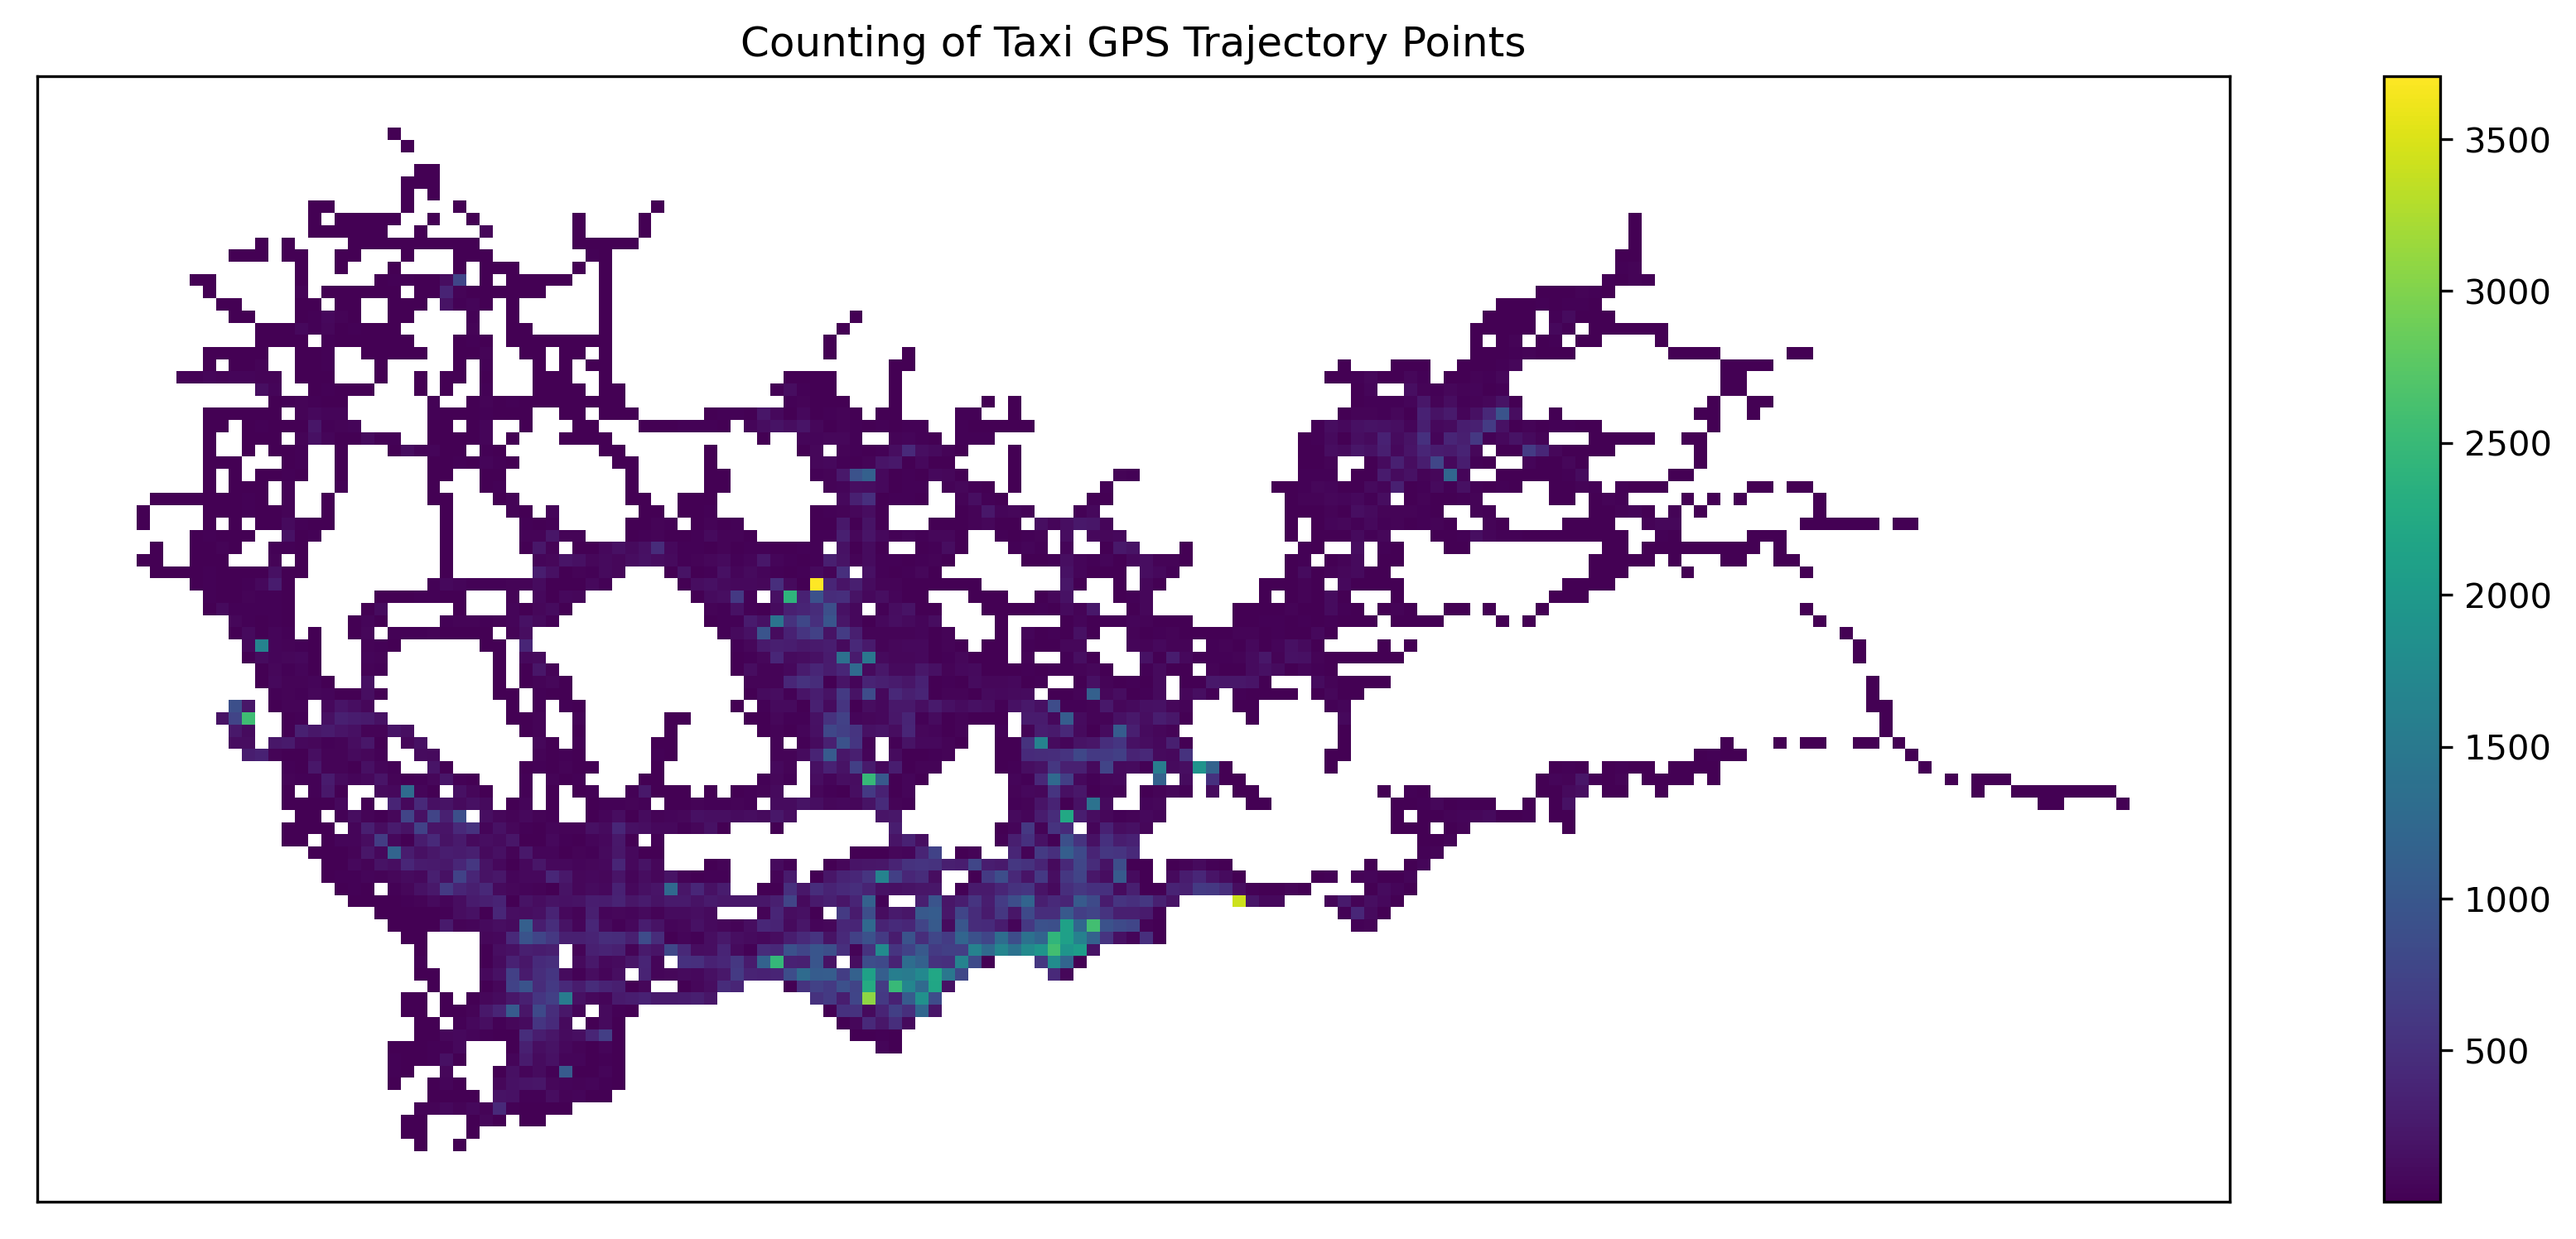

In [24]:
# Plot the grids
fig = plt.figure(1, (16, 6), dpi=300) 
ax1 = plt.subplot(111)

# tbd.plot_map(plt, bounds, zoom=10, style=4)
datatest.plot(ax=ax1, column='VehicleNum', legend=True)
plt.xticks([], fontsize=10)
plt.yticks([], fontsize=10)
plt.title('Counting of Taxi GPS Trajectory Points', fontsize=12);

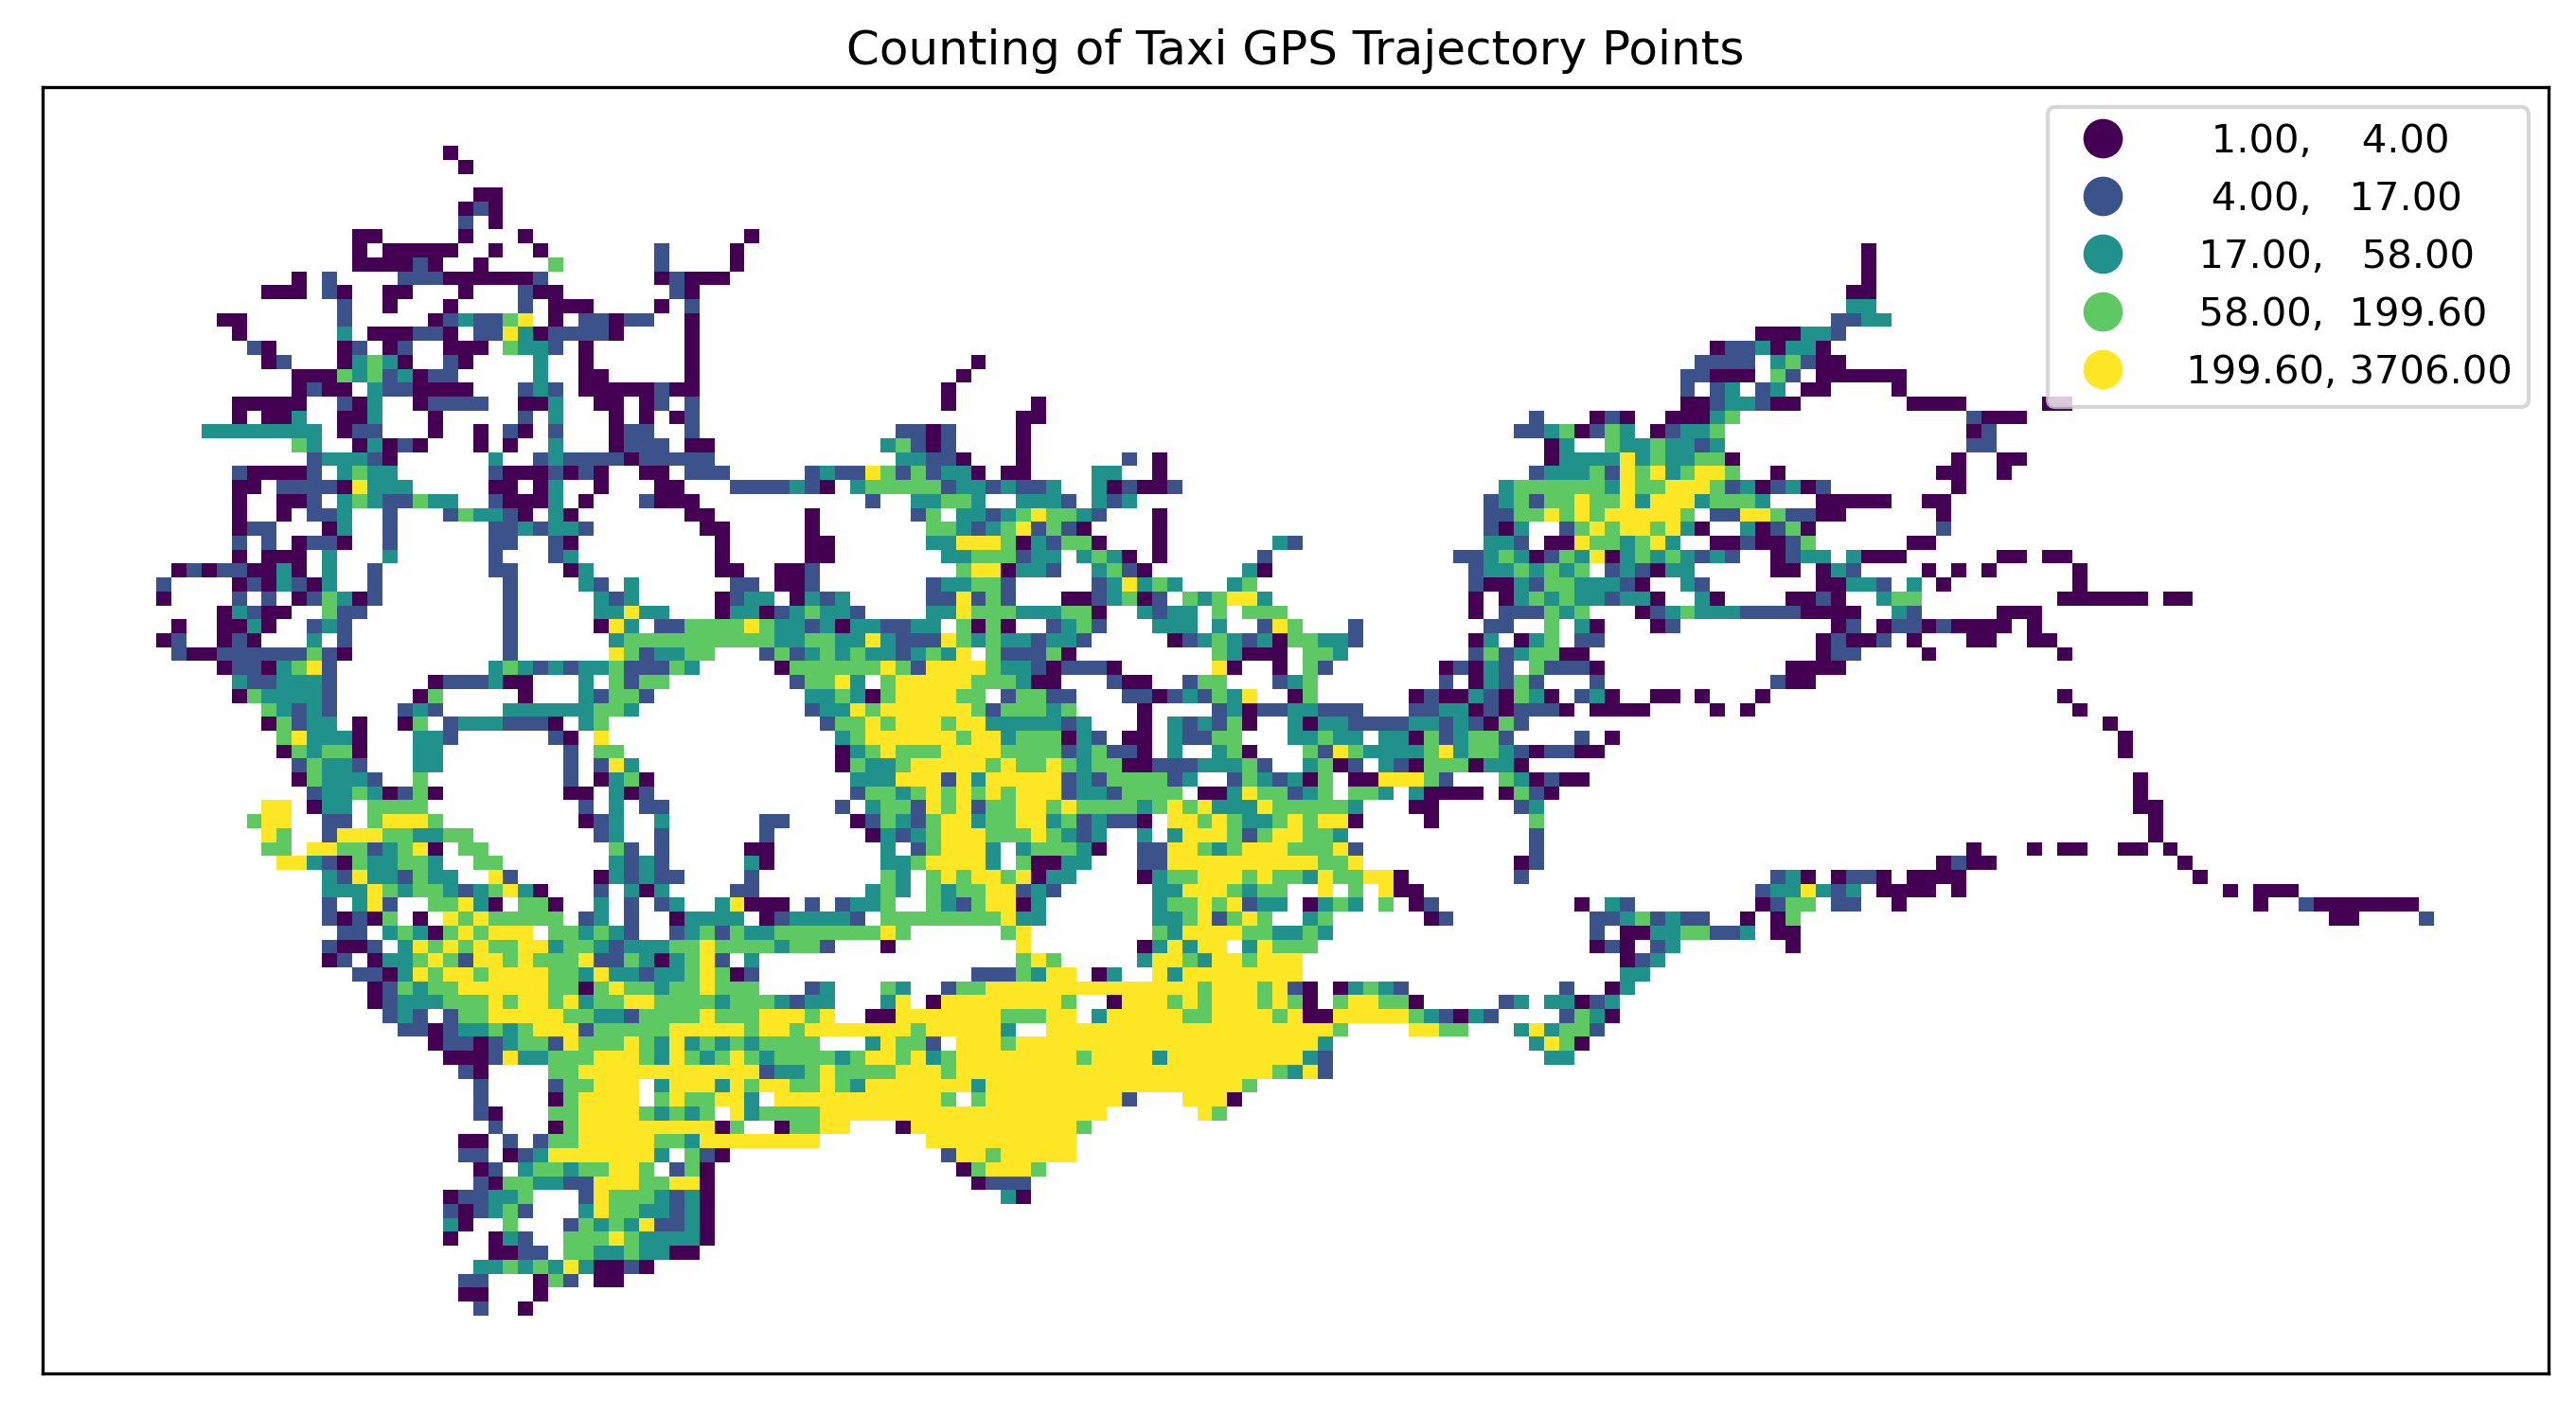

In [25]:
# Plot the grids
fig = plt.figure(1, (16, 6), dpi=300) # 确定图形高为6，宽为8；图形清晰度
ax1 = plt.subplot(111)
datatest.plot(ax=ax1, column='VehicleNum', legend=True, scheme='quantiles')
# plt.legend(fontsize=10)
plt.xticks([], fontsize=10)
plt.yticks([], fontsize=10)
plt.title('Counting of Taxi GPS Trajectory Points', fontsize=12);

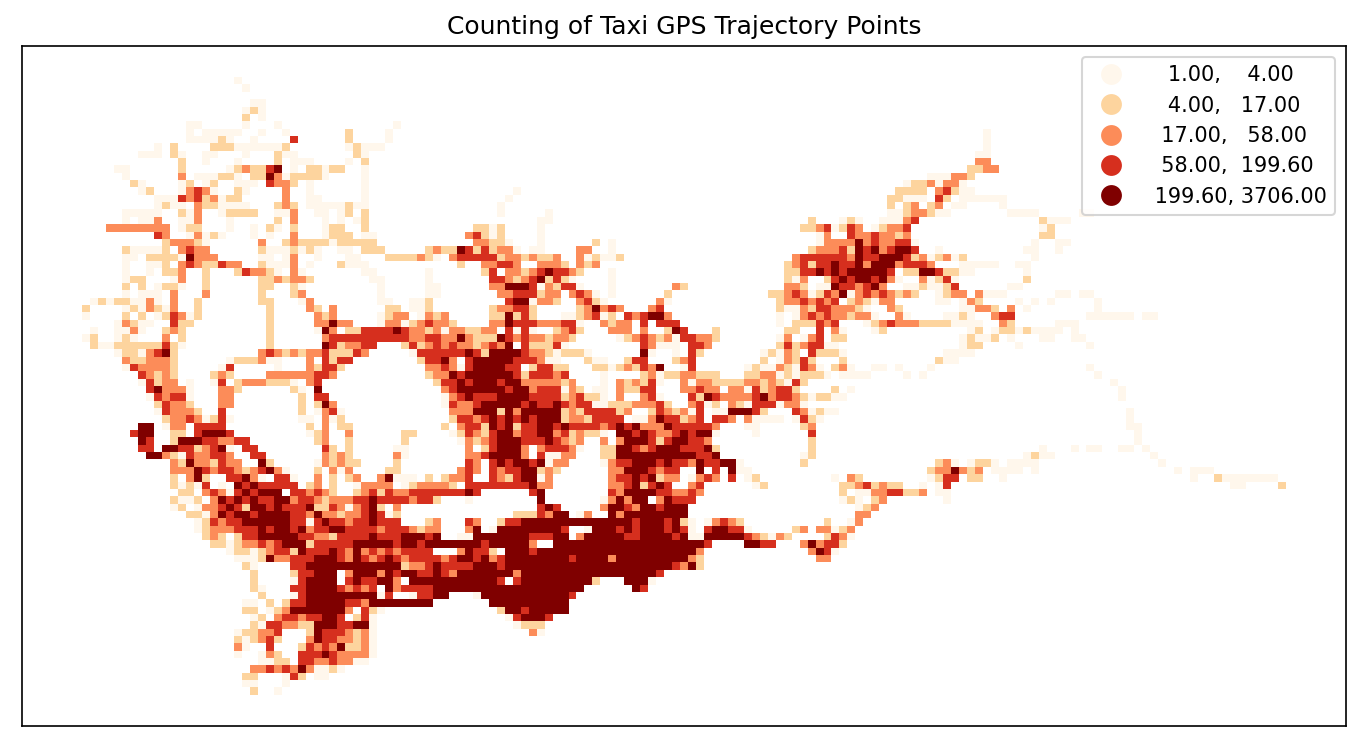

In [26]:
# Plot the grids
fig = plt.figure(1, (16, 6), dpi=150) # 确定图形高为6，宽为8；图形清晰度
ax1 = plt.subplot(111)
datatest.plot(ax=ax1, column='VehicleNum', legend=True, cmap='OrRd', scheme='quantiles')
# plt.legend(fontsize=10)
plt.xticks([], fontsize=10)
plt.yticks([], fontsize=10)
plt.title('Counting of Taxi GPS Trajectory Points', fontsize=12);

# Origin-destination(OD) Extraction and aggregate taxi trips

Use the `tbd.taxigps_to_od` method and pass in the corresponding column name to extract the taxi trip OD:

In [28]:
# Extract taxi OD from GPS data
oddata = tbd.taxigps_to_od(data,col = ['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus'])
oddata

,VehicleNum,stime,slon,slat,etime,elon,elat,ID
427075,22396,00:19:41,114.013016,22.664818,00:23:01,114.021400,22.663918,0
131301,22396,00:41:51,114.021767,22.640200,00:43:44,114.026070,22.640266,1
417417,22396,00:45:44,114.028099,22.645082,00:47:44,114.030380,22.650017,2
376160,22396,01:08:26,114.034897,22.616301,01:16:34,114.035614,22.646717,3
21768,22396,01:26:06,114.046021,22.641251,01:34:48,114.066048,22.636183,4
...,...,...,...,...,...,...,...,...
57666,36805,22:37:42,114.113403,22.534767,22:48:01,114.114365,22.550632,5332
175519,36805,22:49:12,114.114365,22.550632,22:50:40,114.115501,22.557983,5333
212092,36805,22:52:07,114.115402,22.558083,23:03:27,114.118484,22.547867,5334
119041,36805,23:03:45,114.118484,22.547867,23:20:09,114.133286,22.617750,5335


Aggregate the extracted OD and generate LineString GeoDataFrame

In [29]:
# Gridding and aggragate data
od_gdf = tbd.odagg_grid(oddata, params)
od_gdf.head()

/Applications/anaconda3/envs/tbd/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,SLONCOL,SLATCOL,ELONCOL,ELATCOL,count,SHBLON,SHBLAT,EHBLON,EHBLAT,geometry
0,40,62,45,68,1,113.794896,22.678790,113.819258,22.705769,"LINESTRING (113.79490 22.67879, 113.81926 22.7..."
3331,101,36,86,29,1,114.092111,22.561878,114.019026,22.530402,"LINESTRING (114.09211 22.56188, 114.01903 22.5..."
3330,101,35,105,30,1,114.092111,22.557381,114.111601,22.534898,"LINESTRING (114.09211 22.55738, 114.11160 22.5..."
3329,101,34,109,34,1,114.092111,22.552885,114.131091,22.552885,"LINESTRING (114.09211 22.55288, 114.13109 22.5..."
3328,101,34,103,34,1,114.092111,22.552885,114.101856,22.552885,"LINESTRING (114.09211 22.55288, 114.10186 22.5..."


/Applications/anaconda3/envs/tbd/lib/python3.9/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Applications/anaconda3/envs/tbd/lib/python3.9/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)


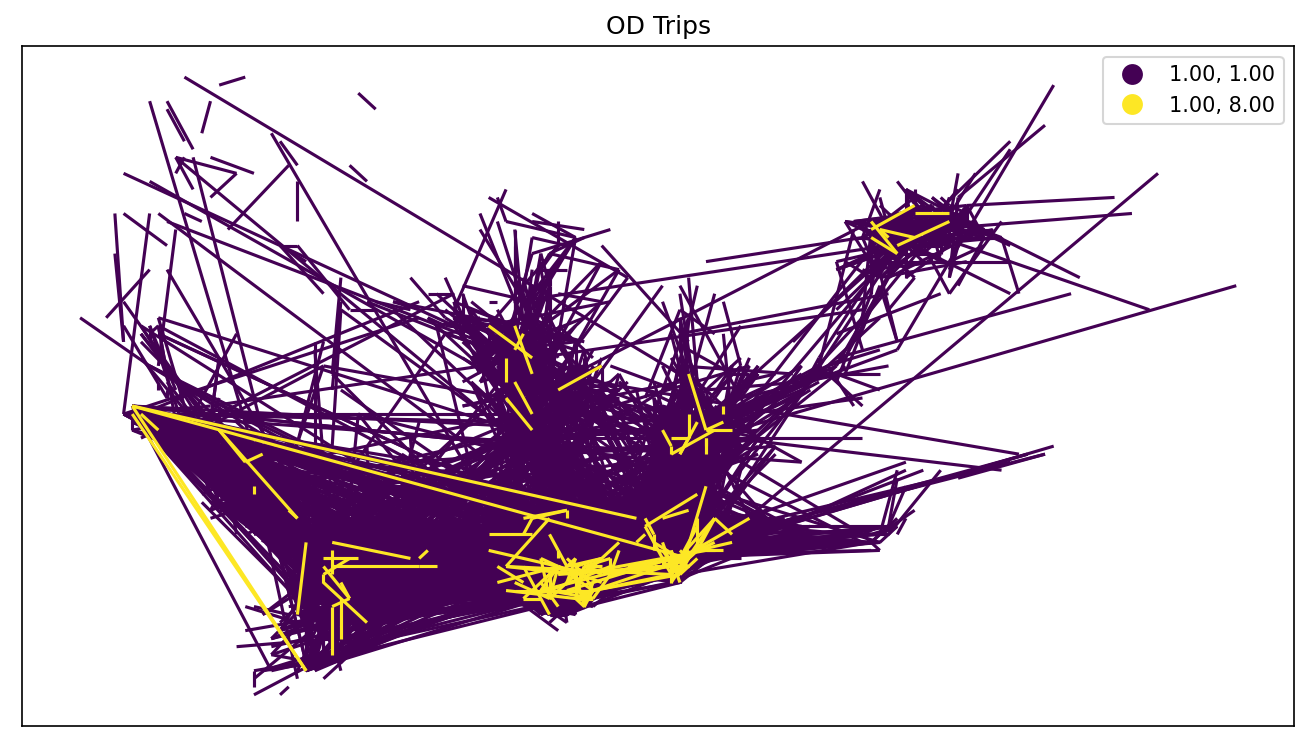

In [30]:
# Plot the grids
fig = plt.figure(1, (16, 6), dpi=150) # 确定图形高为6，宽为8；图形清晰度
ax1 = plt.subplot(111)
# data_grid_count.plot(ax=ax1, column='VehicleNum', legend=True, cmap='OrRd', scheme='quantiles')

od_gdf.plot(ax=ax1, column='count', legend=True, scheme='quantiles')
plt.xticks([], fontsize=10)
plt.yticks([], fontsize=10)
plt.title('OD Trips', fontsize=12);

# Aggregate OD into polygons

`TransBigData` also provides the method for aggregating OD into polygons

/Applications/anaconda3/envs/tbd/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


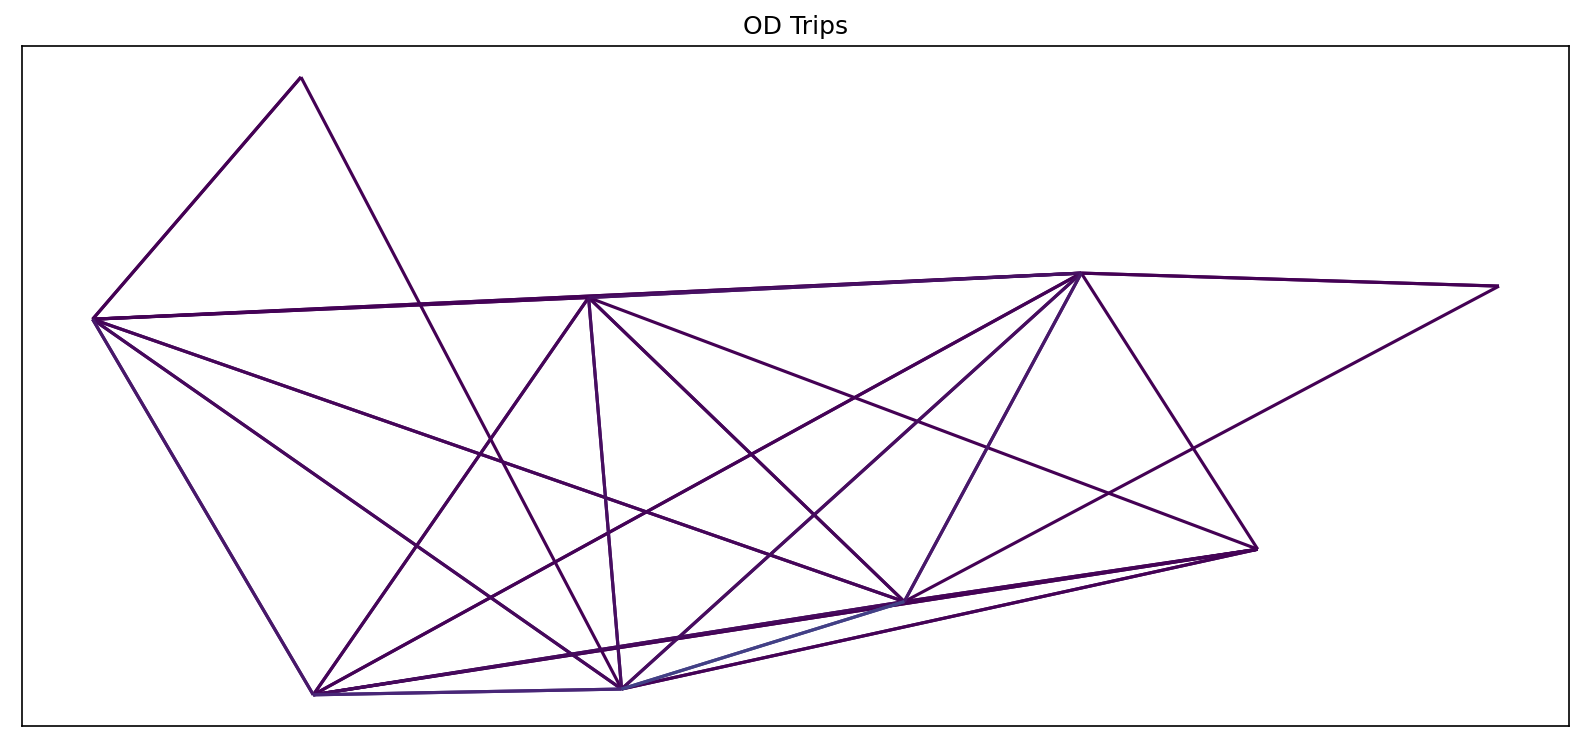

In [32]:
# Aggragate OD data to polygons 
# without passing gridding parameters, the algorithm will map the data 
# to polygons directly using their coordinates
od_gdf = tbd.odagg_shape(oddata, sz, round_accuracy=6)
fig = plt.figure(1, (16, 6), dpi=150) # 确定图形高为6，宽为8；图形清晰度
ax1 = plt.subplot(111)
od_gdf.plot(ax=ax1, column='count')
plt.xticks([], fontsize=10)
plt.yticks([], fontsize=10)
plt.title('OD Trips', fontsize=12);

# Matplotlib-based map drawing

`TransBigData` also provide basemap loading in matplotlib. Before using this method, you need to set your mapboxtoken and the storage location for the basemap, see: [this link](https://transbigdata.readthedocs.io/en/latest/plot_map.html)。`tbd.plot_map` to add basemap and tbd.plotscale to add scale and compass:

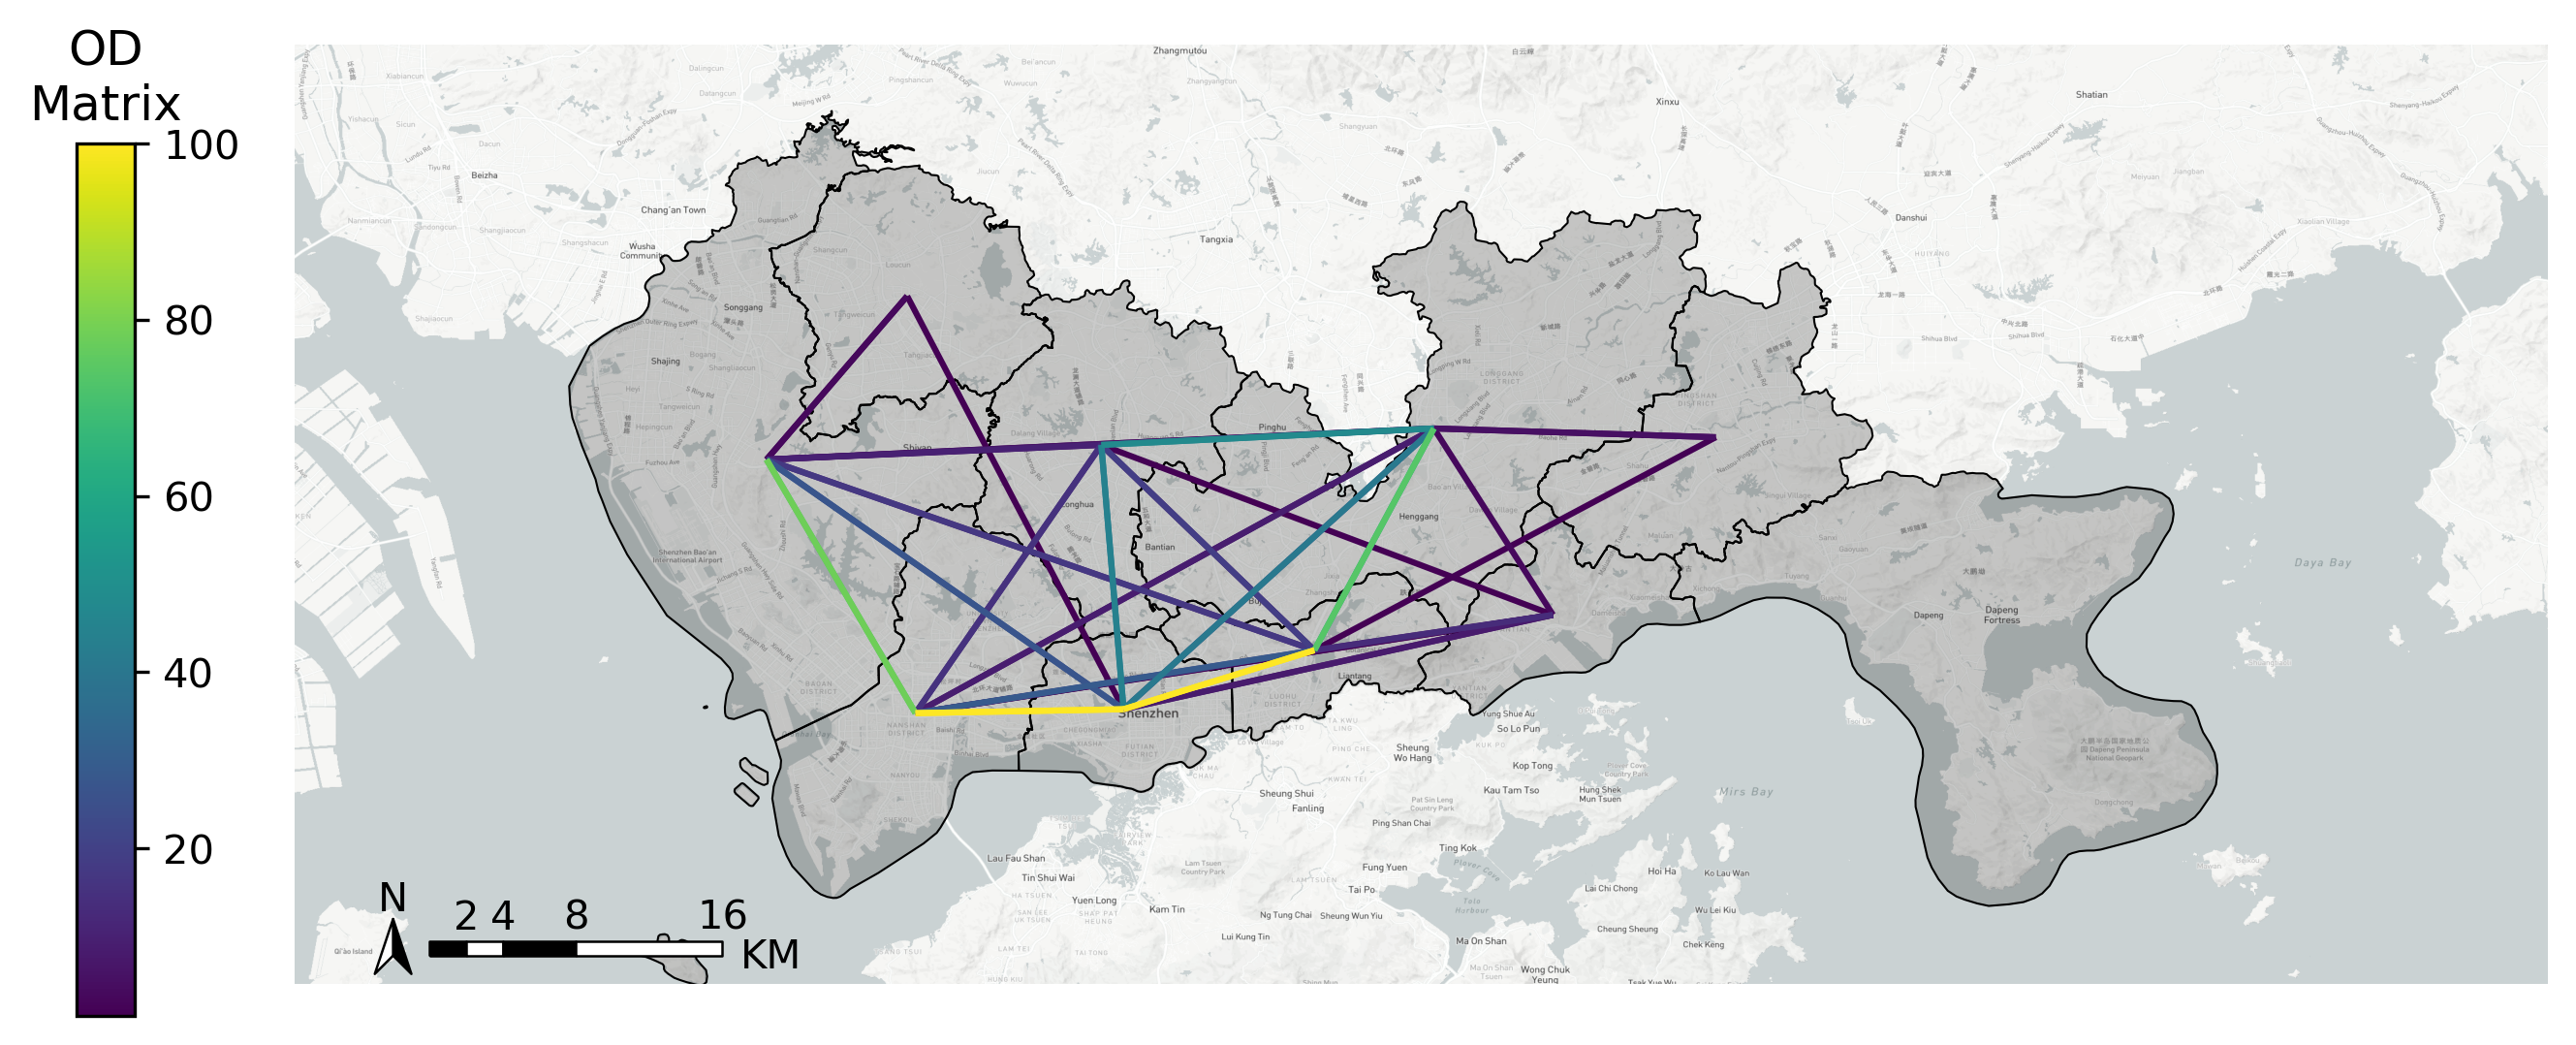

In [33]:
# Create figure
fig = plt.figure(1, (10, 10), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)

# Load basemap
tbd.plot_map(plt, bounds, zoom=12, style=4)

# Define an ax for colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('OD\nMatrix')
plt.sca(ax)

# Plot the OD
od_gdf.plot(ax=ax, vmax=100, column='count', cax=cax, legend=True)

# Plot the polygons
sz.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0.2), linewidths=0.5)

# Add compass and scale
tbd.plotscale(ax, bounds=bounds, textsize=10, compasssize=1, accuracy=2000, rect=[0.06, 0.03], zorder=10)
plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.show()

# Extraction of taxi trajectpries

Using `tbd.taxigps_traj_point` method, inputing GPS data and OD data, trajectory points can be extracted

In [34]:
data_deliver, data_idle = tbd.taxigps_traj_point(data,oddata,col=['VehicleNum', 
                                                                  'Time', 
                                                                  'Lng', 
                                                                  'Lat', 
                                                                  'OpenStatus'])

In [35]:
data_deliver.head()

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed,LONCOL,LATCOL,ID,flag
427075,22396,00:19:41,114.013016,22.664818,1,63.0,85.0,59.0,0.0,1.0
427085,22396,00:19:49,114.014030,22.665483,1,55.0,85.0,59.0,0.0,1.0
416622,22396,00:21:01,114.018898,22.662500,1,1.0,86.0,58.0,0.0,1.0
427480,22396,00:21:41,114.019348,22.662300,1,7.0,86.0,58.0,0.0,1.0
416623,22396,00:22:21,114.020615,22.663366,1,0.0,86.0,59.0,0.0,1.0


In [36]:
data_idle.head()

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed,LONCOL,LATCOL,ID,flag
416628,22396,00:23:01,114.021400,22.663918,0,25.0,86.0,59.0,0.0,0.0
401744,22396,00:25:01,114.027115,22.662100,0,25.0,88.0,58.0,0.0,0.0
394630,22396,00:25:41,114.024551,22.659834,0,21.0,87.0,58.0,0.0,0.0
394671,22396,00:26:21,114.022797,22.658367,0,0.0,87.0,57.0,0.0,0.0
394672,22396,00:26:29,114.022797,22.658367,0,0.0,87.0,57.0,0.0,0.0


Generate delivery and idle trajectories from trajectory points

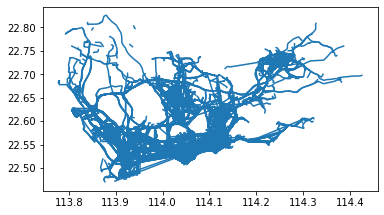

In [37]:
traj_deliver = tbd.points_to_traj(data_deliver)
traj_deliver.plot();

<AxesSubplot:>

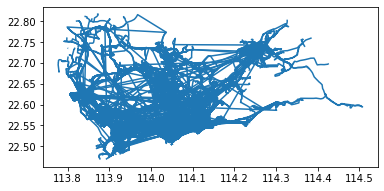

In [38]:
traj_idle = tbd.points_to_traj(data_idle[data_idle['OpenStatus'] == 0])
traj_idle.plot()

# Trajectories visualization

Built-in visualization capabilities of `TransBigData` leverage the visualization package `keplergl` to interactively visualize data on Jupyter notebook with simple code.
To use this method, please install the `keplergl` package for python:

> pip install keplergl

Detailed information please see [this link](https://transbigdata.readthedocs.io/en/latest/visualization.html)

Visualization of trajectory data:

In [19]:
tbd.visualization_trip(data_deliver)

整理轨迹数据...
生成可视化...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hizm36i', 'type': …